In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi
r_m = 0.1
N0_squared = 100

k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
def dsdt(t, s, U):
    return W @ s + U * (L @ s)

def dUdt(t, s, U):
    psi_e, _, psi_p, _ = s
    return 0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p - r_m * U

In [4]:
def rhs(t, y):
    s, U = y[:4], y[4]
    ds = dsdt(t, s, U)
    dU = dUdt(t, s, U)
    return np.concatenate((ds, [dU]))

initial_state = np.array([0.1, 0.1, 0, 0, 0.001])
#initial_state = np.array([0, 0, 0, 0, 0.001])
t_span = (0, 25)

In [5]:
##Using Scipy's solve_ivp method-

sol = solve_ivp(rhs, t_span, initial_state, method='DOP853', t_eval=np.linspace(t_span[0], t_span[1], 100000), vectorized=True, dense_output=True)

t = sol.t

y = sol.y

R_value = 0.25 * k * (k_plus**2- k_e**2) * sol.y[0] * sol.y[2]

In [53]:
# #Using Euler's Method-

# def eulers_method(rhs, y0, t_span, dt):
#     t0, tf = t_span
#     t = np.arange(t0, tf + dt, dt)
#     y = np.zeros((len(y0), len(t)))
#     y[:, 0] = y0

#     for i in range(1, len(t)):
#         y[:, i] = y[:, i-1] + dt * rhs(t[i-1], y[:, i-1])

#     return t, y

# dt = 0.00001
# t_e, y_e = eulers_method(rhs, initial_state, t_span, dt)

In [6]:
##Using RK4 Method-

def rk4_method(rhs, y0, t_span, dt):
    t0, tf = t_span
    t = np.arange(t0, tf + dt, dt)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(t[i-1], y[:, i-1])
        k2 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k1)
        k3 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k2)
        k4 = rhs(t[i-1] + dt, y[:, i-1] + dt * k3)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

dt = 0.01
t_rk4, y_rk4 = rk4_method(rhs, initial_state, t_span, dt)
R_value_rk4 = 0.25 * k * (k_plus**2 - k_e**2) * y_rk4[0] * y_rk4[2]

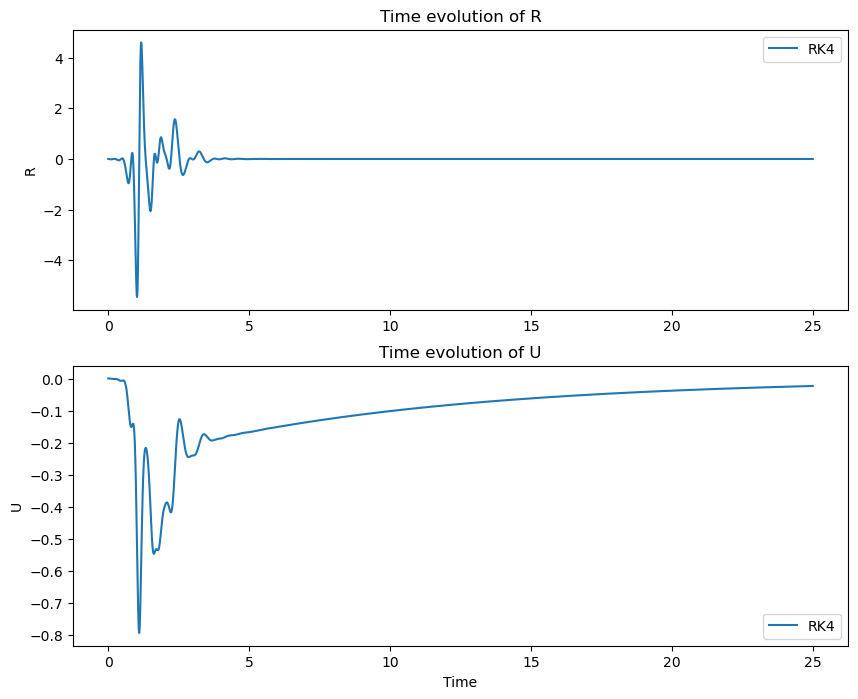

In [7]:
##Both Euler's method and solve_ivp together

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

#axs[0].plot(t, R_value, '-', label='solve_ivp')
axs[0].plot(t_rk4, R_value_rk4, '-', label='RK4')
axs[0].set_title("Time evolution of R")
axs[0].set_ylabel("R")
axs[0].legend()


#axs[1].plot(t, sol.y[4], '-', label="solve_ivp")
axs[1].plot(t_rk4, y_rk4[4], '-', label="RK4")
axs[1].set_title("Time evolution of U")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("U")
axs[1].legend()

plt.show()

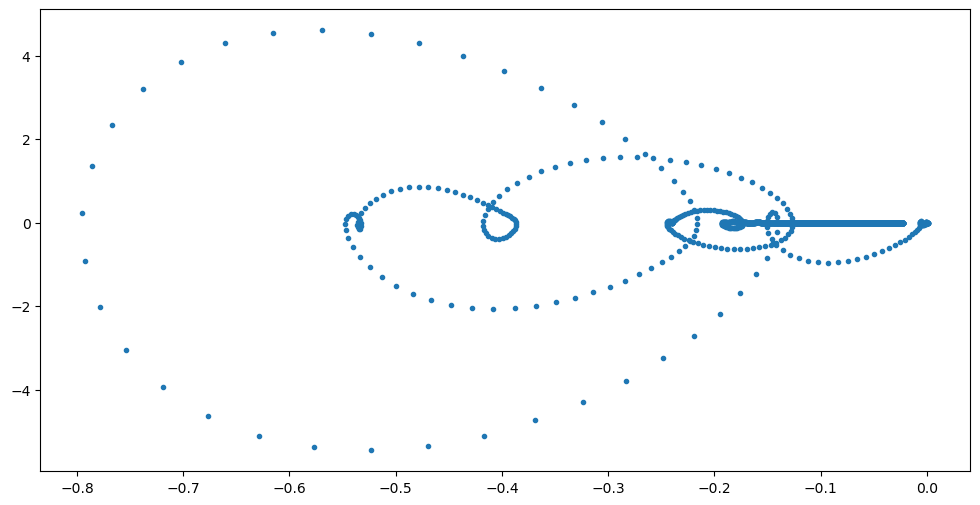

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_rk4[4], R_value_rk4,'.')

In [10]:
t_span = (0, 10)
dt_values = [0.1, 0.01, 0.001]
#dt_values = [0.1, 0.01, 0.001]

t_k_dts = []
y_k_dts = []
R_value_k_dts = []

# Generate the variables for each dt value
for dt in dt_values:
    t_k, y_k = rk4_method(rhs, initial_state, t_span, dt)
    R_value_k = 0.25 * k * (k_plus**2 - k_e**2) * y_k[0] * y_k[2]
    
    t_k_dts.append(t_k)
    y_k_dts.append(y_k)
    R_value_k_dts.append(R_value_k)

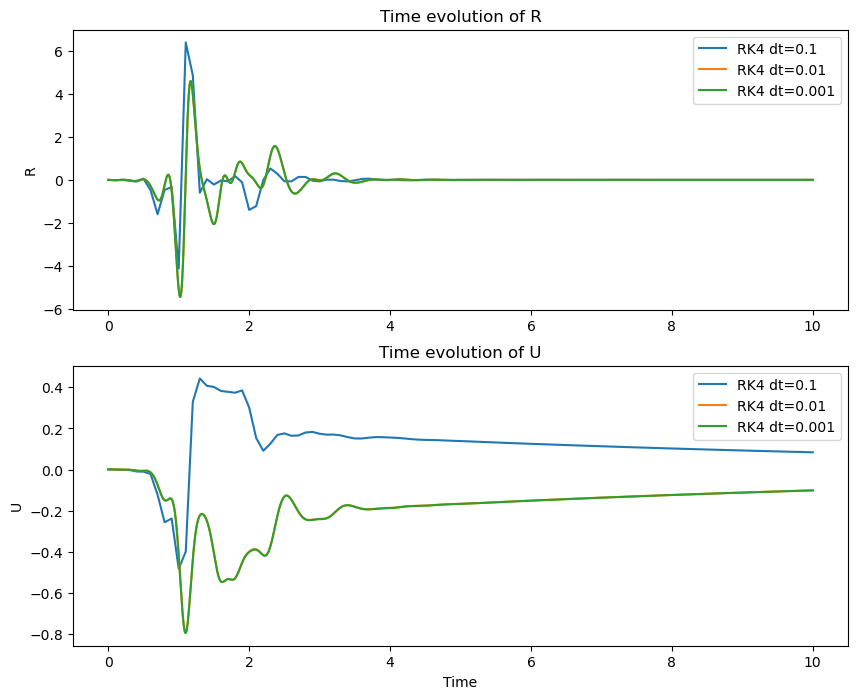

In [11]:
# Create the plots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for t_k, R_value_k, dt in zip(t_k_dts, R_value_k_dts, dt_values):
    axs[0].plot(t_k, R_value_k, '-', label=f'RK4 dt={dt}')
    axs[0].set_title("Time evolution of R")
    axs[0].set_ylabel("R")
    axs[0].legend()
    #axs[0].set_xlim(2.43,2.45)
    #axs[0].set_ylim(1.0,1.1)

for t_k, y_k, dt in zip(t_k_dts, y_k_dts, dt_values):
    axs[1].plot(t_k, y_k[4], '-', label=f"RK4 dt={dt}")
    axs[1].set_title("Time evolution of U")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("U")
    axs[1].legend()
    #axs[1].set_xlim(5,5.1)
    #axs[1].set_ylim(-0.1675,-0.1660)

plt.show()

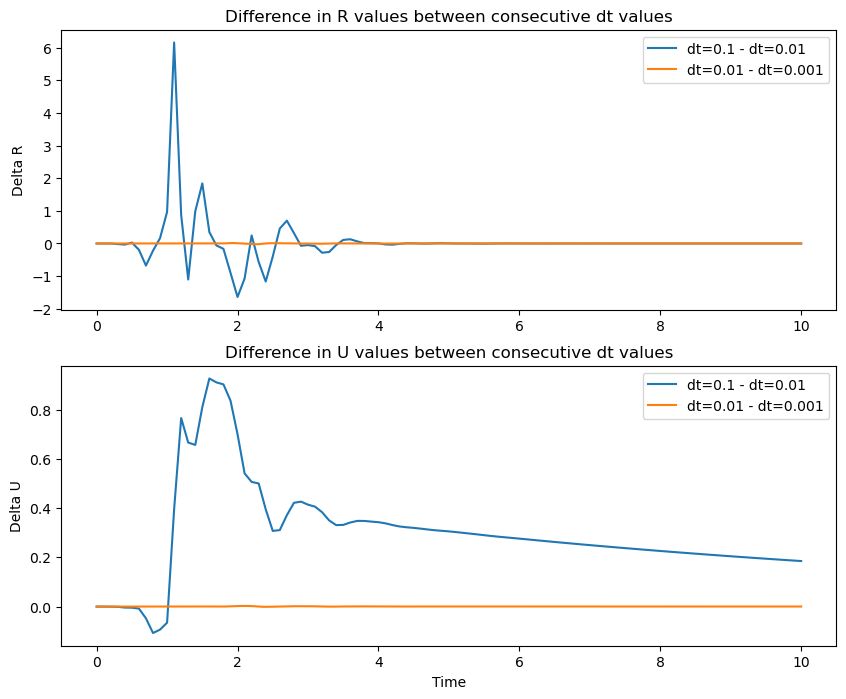

In [12]:
fig, axs_diff = plt.subplots(2, 1, figsize=(10, 8))

for i in range(len(dt_values) - 1):
    
    R_diff = R_value_k_dts[i] - np.interp(t_k_dts[i], t_k_dts[i+1], R_value_k_dts[i+1])

    axs_diff[0].plot(t_k_dts[i], R_diff, '-', label=f"dt={dt_values[i]} - dt={dt_values[i+1]}")
    
axs_diff[0].set_title("Difference in R values between consecutive dt values")
axs_diff[0].set_ylabel("Delta R")
axs_diff[0].legend()

for i in range(len(dt_values) - 1):
    
    U_diff = y_k_dts[i][4] - np.interp(t_k_dts[i], t_k_dts[i+1], y_k_dts[i+1][4])

    axs_diff[1].plot(t_k_dts[i], U_diff, '-', label=f"dt={dt_values[i]} - dt={dt_values[i+1]}")
    
axs_diff[1].set_title("Difference in U values between consecutive dt values")
axs_diff[1].set_xlabel("Time")
axs_diff[1].set_ylabel("Delta U")
axs_diff[1].legend()

plt.show()

In [58]:
def compute_psi_b_U(y, X, Z, m_U):
    psi_e = y[0]
    psi_plus = y[2]
    b_e = y[1]
    b_plus = y[3]
    U = y[4]

    psi = psi_e * np.sin(k * X) * np.sin(m * Z) + psi_plus * np.cos(k * X) * np.cos((m + m_U) * Z)
    b = b_e * np.cos(k * X) * np.sin(m * Z) + b_plus * np.sin(k * X) * np.cos((m + m_U) * Z)
    U_z_t = U * np.sin(m_U * Z)

    return psi, b, U_z_t

# Parameters
x = np.linspace(0, 1, 100)
z = np.linspace(0, 1, 100)
X, Z = np.meshgrid(x, z)

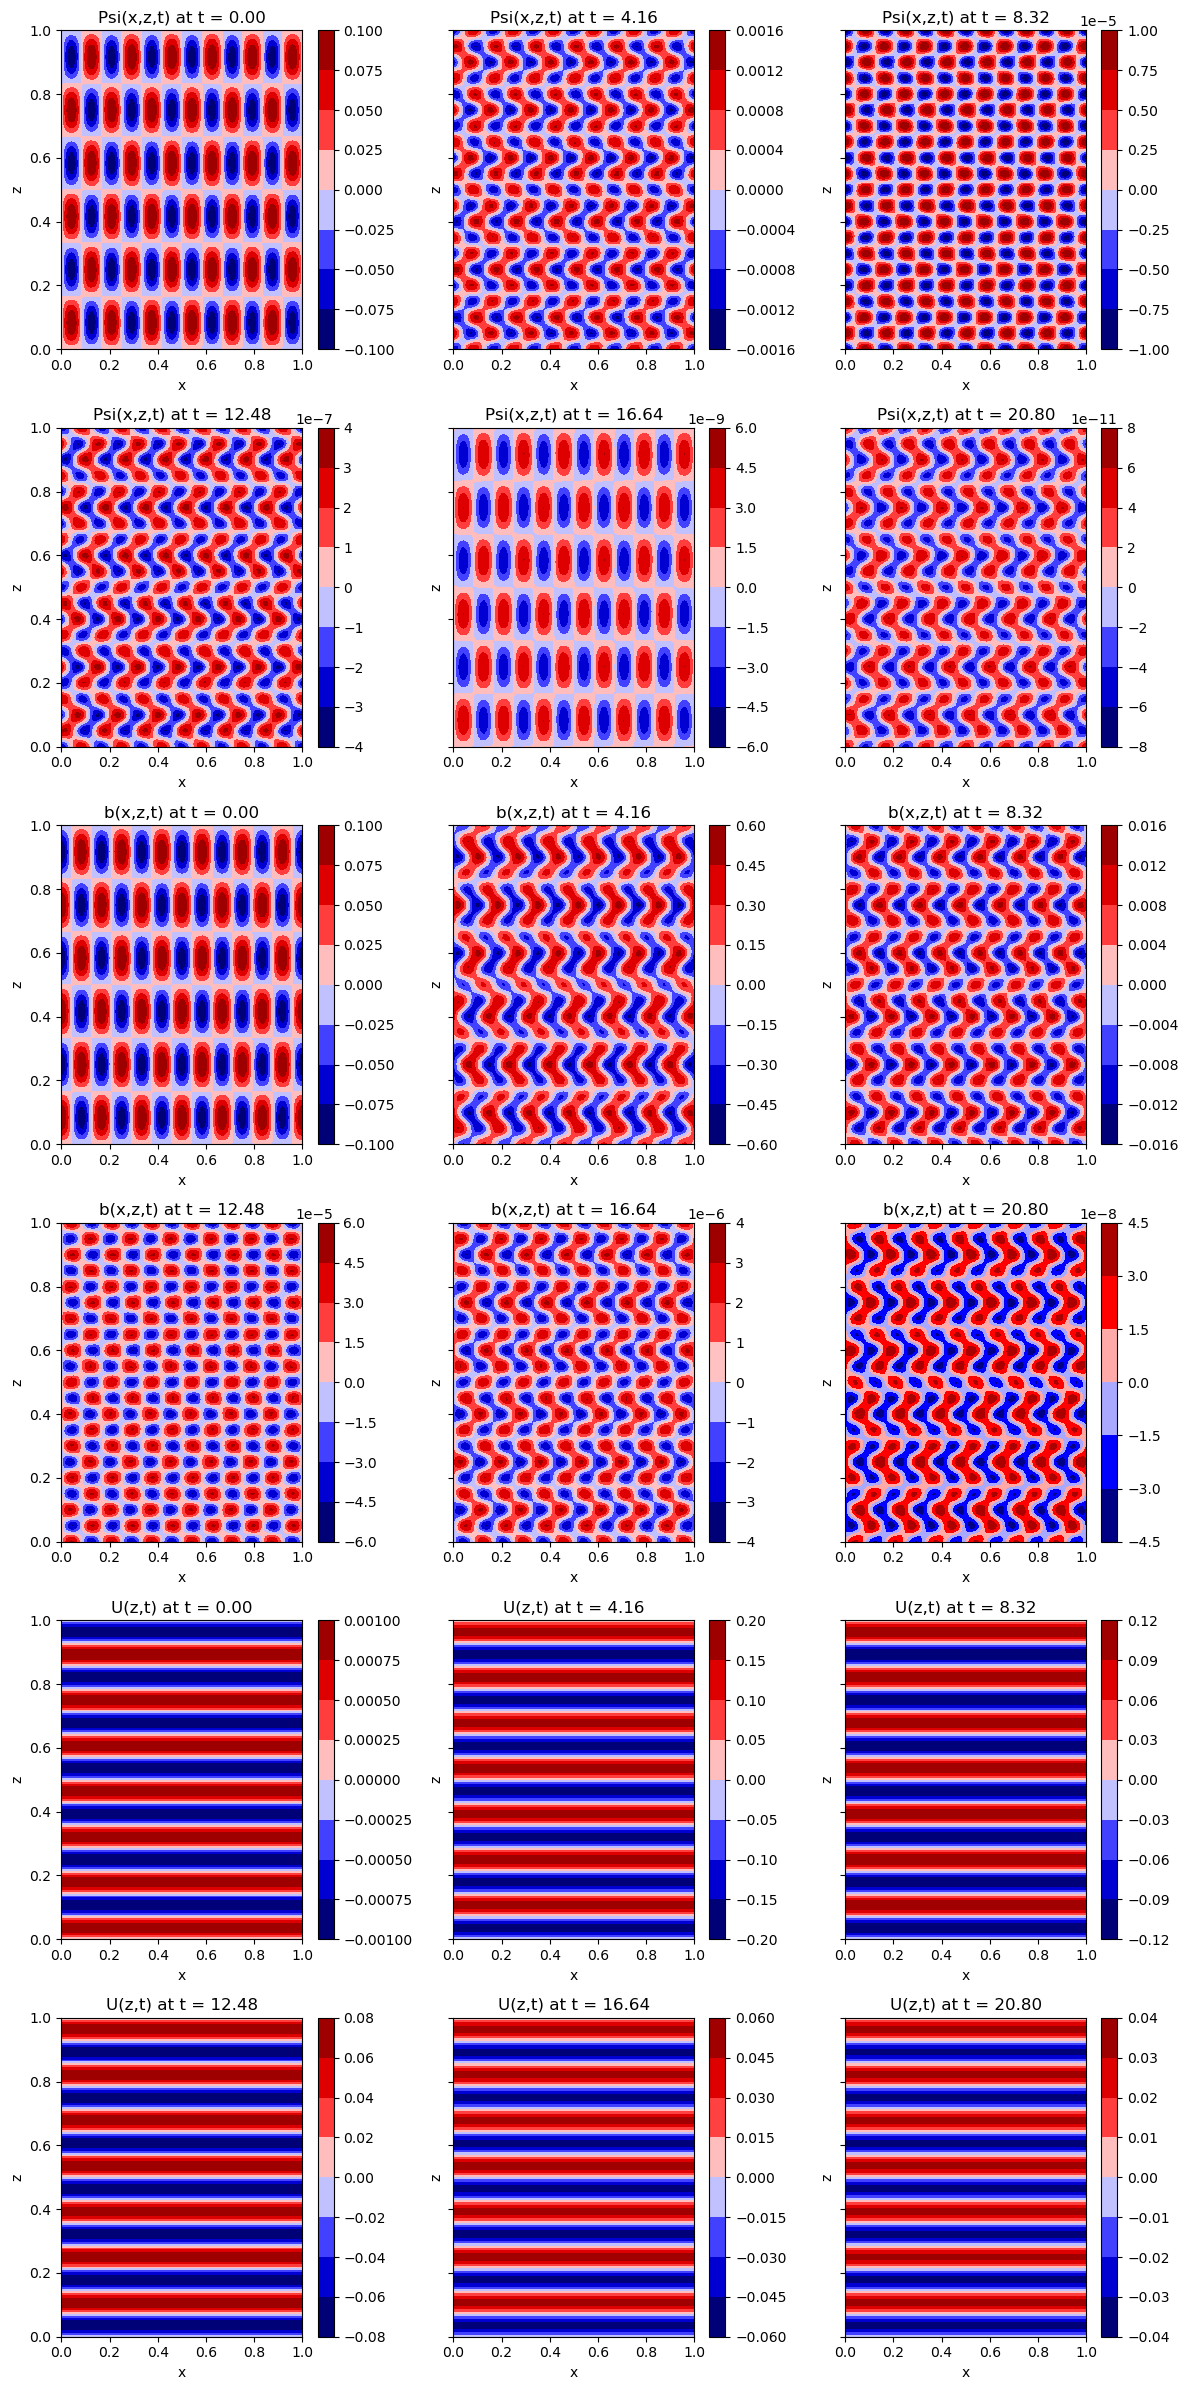

In [59]:
def plot_spatial_visualization(t_indices, y_rk4, X, Z, m_U):
    n_plots = len(t_indices)
    ncols = 3
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows*3, ncols, figsize=(12, 4 * nrows*3), sharey=True)
    axes = axes.ravel()

    for i, t_index in enumerate(t_indices):
        psi, b, U_z_t = compute_psi_b_U(y_rk4[:, t_index], X, Z, m_U)
        
        cmap = 'seismic'
        
        c_psi = axes[i].contourf(X, Z, psi, cmap=cmap)
        axes[i].set_title(f"Psi(x,z,t) at t = {t_rk4[t_index]:.2f}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("z")
        fig.colorbar(c_psi, ax=axes[i])

        c_b = axes[i + n_plots].contourf(X, Z, b, cmap=cmap)
        axes[i + n_plots].set_title(f"b(x,z,t) at t = {t_rk4[t_index]:.2f}")
        axes[i + n_plots].set_xlabel("x")
        axes[i + n_plots].set_ylabel("z")
        fig.colorbar(c_b, ax=axes[i + n_plots])

        c_U = axes[i + 2 * n_plots].contourf(X, Z, U_z_t, cmap=cmap)
        axes[i + 2 * n_plots].set_title(f"U(z,t) at t = {t_rk4[t_index]:.2f}")
        axes[i + 2 * n_plots].set_xlabel("x")
        axes[i + 2 * n_plots].set_ylabel("z")
        fig.colorbar(c_U, ax=axes[i + 2 * n_plots])
        

    plt.tight_layout()
    plt.show()

# Choose time indices at regular intervals
n_plots = 6
time_indices = np.arange(0, len(t_rk4), len(t_rk4) // n_plots)[:n_plots]

plot_spatial_visualization(time_indices, y_rk4, X, Z, m_U)